In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [3]:
#  mounts the Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# test path from the drive
test_path = '/content/drive/MyDrive/Kaggle/Digit_Recognizer/test.csv'

In [6]:
# train path from the drive
train_path = '/content/drive/MyDrive/Kaggle/Digit_Recognizer/train.csv'

In [7]:
# copying the file from drive to colab
!cp "{test_path}" .

In [8]:
# copying the file from drive to colab
!cp "{train_path}" .

In [9]:
test_df = pd.read_csv('test.csv')

In [10]:
train_df = pd.read_csv('train.csv')

In [85]:
train_df.head(2)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [86]:
train_df.shape

(42000, 785)

In [87]:
test_df.shape

(28000, 784)

In [11]:
# Drop 'label' column
X_train = train_df.drop(labels = ["label"],axis = 1) 

In [12]:
# only label column
Y_train = train_df["label"]

Each number amount:

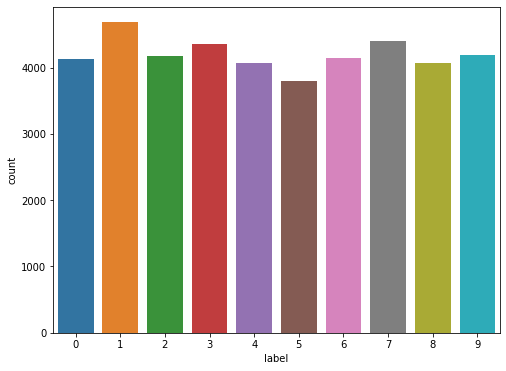

In [15]:
plt.figure(figsize=(8,6))
sns.countplot(x = Y_train)
plt.show()

In [16]:
Y_train.value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

# Preprocessing Data

## Missing values

In [17]:
X_train.isnull().sum().agg(['count', 'mean', 'sum', 'min', 'max'])

count    784.0
mean       0.0
sum        0.0
min        0.0
max        0.0
dtype: float64

In [18]:
test_df.isnull().sum().agg(['count', 'mean', 'sum', 'min', 'max'])

count    784.0
mean       0.0
sum        0.0
min        0.0
max        0.0
dtype: float64

No missing values.

## Normalization

We should normalize the X data:

In [19]:
X_train.iloc[0].max()

255

In [20]:
X_train.iloc[0].min()

0

In [13]:
X_train = X_train / 255.0
test_df = test_df / 255.0

In [22]:
X_train.iloc[0].max()

1.0

## Reshaping

Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1):

In [14]:
X_train = X_train.values.reshape(-1,28,28,1)
test_df = test_df.values.reshape(-1,28,28,1)

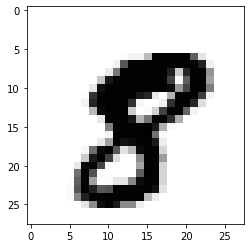

In [15]:
single_image = plt.imshow(X_train[10][:,:,0], cmap='Greys')


Our labels are literally categories of numbers. We need to translate this to be "one hot encoded" so our CNN can understand, otherwise it will think this is some sort of regression problem on a continuous axis. Keras has an easy to use function for this:

In [16]:
from tensorflow.keras.utils import to_categorical

In [94]:
Y_train[0]

1

In [17]:
Y_train_cat = to_categorical(Y_train)

In [96]:
print(Y_train_cat[0])

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


## Split training and valdiation set

In [18]:
# only 15% for validation set
X_train, X_valid, y_train, y_valid = train_test_split(X_train, Y_train_cat, test_size=0.15)

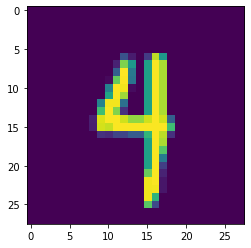

In [19]:
g = plt.imshow(X_train[5][:,:,0])

In [20]:
y_train[5]

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.], dtype=float32)

## Creating and Training Model

In [29]:
model = Sequential()

In [30]:
# CONVOLUTIONAL LAYER
model.add(Conv2D(filters=32, kernel_size=(4,4), input_shape=(28, 28, 1), activation='relu')) # filters almost always 2^n
# POOLING LAYER
model.add(MaxPool2D(pool_size=(2,2))) # in this case, half of the kernel size

# FLATTEN IMAGES FROM 28 by 28 to 764 BEFORE FINAL LAYER
model.add(Flatten())

# 128 NEURONS IN DENSE HIDDEN LAYER
model.add(Dense(128, activation='relu'))

# LAST LAYER IS THE CLASSIFIER, THUS 10 POSSIBLE CLASSES
model.add(Dense(10, activation='softmax'))  # SOFTMAX --> MULTICLASS PROBLEM

# https://keras.io/metrics/
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

In [43]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 25, 25, 32)        544       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 32)        16416     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 32)          16416     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               6

In [21]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)

In [48]:
model.fit(X_train, y_train, epochs=15, validation_data=(X_valid, y_valid), callbacks=[early_stop])

Epoch 1/15
1116/1116 [==============================] - 85s 76ms/step - loss: 0.1584 - accuracy: 0.9515 - val_loss: 0.0667 - val_accuracy: 0.9790
Epoch 2/15
1116/1116 [==============================] - 84s 75ms/step - loss: 0.0486 - accuracy: 0.9848 - val_loss: 0.0532 - val_accuracy: 0.9825
Epoch 3/15
1116/1116 [==============================] - 84s 75ms/step - loss: 0.0350 - accuracy: 0.9887 - val_loss: 0.0428 - val_accuracy: 0.9875
Epoch 4/15
1116/1116 [==============================] - 84s 75ms/step - loss: 0.0257 - accuracy: 0.9924 - val_loss: 0.0394 - val_accuracy: 0.9890
Epoch 5/15
1116/1116 [==============================] - 83s 75ms/step - loss: 0.0208 - accuracy: 0.9929 - val_loss: 0.0376 - val_accuracy: 0.9886
Epoch 6/15
1116/1116 [==============================] - 83s 75ms/step - loss: 0.0155 - accuracy: 0.9950 - val_loss: 0.0449 - val_accuracy: 0.9873
Epoch 7/15
1116/1116 [==============================] - 83s 75ms/step - loss: 0.0140 - accuracy: 0.9953 - val_loss: 0.0448 -

In [49]:
model.metrics_names

['loss', 'accuracy']

In [50]:
metrics = pd.DataFrame(model.history.history)

In [51]:
metrics

,loss,accuracy,val_loss,val_accuracy
0,0.158411,0.951457,0.066742,0.979048
1,0.048617,0.984818,0.053151,0.982540
2,0.034977,0.988739,0.042755,0.987460
3,0.025681,0.992381,0.039390,0.989048
4,0.020832,0.992913,0.037599,0.988571
5,0.015521,0.994958,0.044859,0.987302
6,0.013963,0.995266,0.044814,0.988413
7,0.011639,0.996247,0.042472,0.988730


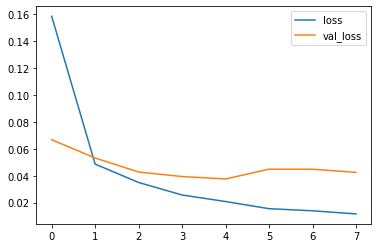

In [52]:
metrics[['loss', 'val_loss']].plot()
plt.show()

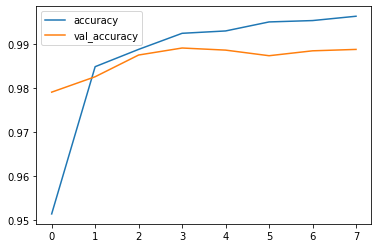

In [53]:
metrics[['accuracy', 'val_accuracy']].plot()
plt.show()

In [54]:
print(model.metrics_names)
print(model.evaluate(X_valid, y_valid, verbose = 0))

['loss', 'accuracy']
[0.042471930384635925, 0.9887301325798035]


In [55]:
# model.save('mnist_CNN_kaggle_model.h5')

In [36]:
# grab model and scaler
mnist_model = load_model("mnist_CNN_kaggle_model.h5")

## Image Generator

In [22]:
image_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 5%
                               height_shift_range=0.10, # Shift the pic height by a max of 5%
                               #rescale=1/255, # our data is already scaled.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

In [35]:
# results = model.fit_generator(X_train, y_train, epochs=20,
#                               validation_data=[X_valid, y_valid],
#                               callbacks=[early_stop])

In [37]:
pred_test = mnist_model.predict(test_df)

In [38]:
pred_test.shape

(28000, 10)